# Klasifikasi TEKS menggunakan RNN


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# TensorFlow and NLP tools
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import (
Embedding, LSTM, Dense, Activation, Bidirectional, Dropout, GRU, 
SimpleRNN, BatchNormalization, AlphaDropout, LayerNormalization)

from tensorflow.keras.optimizers import Adam

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

2025-08-28 05:10:48.308978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756357848.508851      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756357848.565616      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data Preprocessing


In [2]:
df = pd.read_csv('/kaggle/input/dataset-klasifikasi-teks-dengan-rnn/transformer.csv')

In [3]:
df

,data,labels
0,Fuming Robinson blasts officials England coac...,sport
1,Veteran Martinez wins Thai title Conchita Mar...,sport
2,Spurs to sign Iceland U21 star Tottenham are ...,sport
3,Mexicans tracking unhappy Juninho Mexican out...,sport
4,Mirza makes Indian tennis history Teenager Sa...,sport
...,...,...
923,Howard backs stem cell research Michael Howar...,politics
924,Blair dismisses quit claim report Tony Blair ...,politics
925,Kennedy to make temple address Charles Kenned...,politics
926,Terror powers expose tyranny The Lord Chancel...,politics


In [4]:
df['labels'].value_counts()

labels
sport       511
politics    417
Name: count, dtype: int64

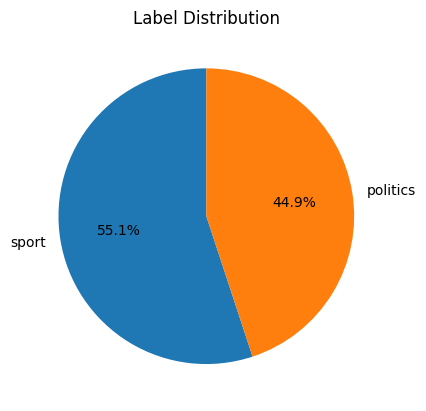

In [5]:
df['labels'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution')
plt.ylabel('')
plt.show()

In [6]:
df.isna().sum()

data      0
labels    0
dtype: int64

## 2. Configuration Parameters

In [7]:
vocab_size = 5000        # Maximum number of words to keep in vocabulary
embedding_dim = 64       # Dimension of word embedding vectors
max_length = 200        # Maximum sequence length (padding/truncating)
oov_tok = '<OOV>'       # Token for out-of-vocabulary words

In [8]:
labels = df['labels'].tolist()
data = df['data'].tolist()

In [9]:
# Verify the extraction
print(f"Number of samples: {len(labels)}")
print(f"Number of texts: {len(data)}")
print(f"\nUnique labels: {set(labels)}")
print(f"\nFirst label: {labels[0]}")
print(f"First text (truncated): {data[0][:200]}...")

Number of samples: 928
Number of texts: 928

Unique labels: {'sport', 'politics'}

First label: sport
First text (truncated): Fuming Robinson blasts officials  England coach Andy Robinson insisted he was "livid" after his side were denied two tries in Sundays 19-13 Six Nations loss to Ireland in Dublin.  Mark Cuetos first-ha...


## 3. Data Splitting

In [10]:
# Optional: Shuffle before splitting for better distribution
from sklearn.model_selection import train_test_split

train_data, validation_data, train_labels, validation_labels = train_test_split(
    data, labels, 
    test_size=0.2,
    random_state=42,  # For reproducibility
    stratify=labels  # Ensures equal distribution of labels in both sets
)

## 4. Text Tokenization

In [11]:
# Initialize token with vocabulary limit and OOV token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Fit
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

print(f"Total unique words found: {len(word_index)}")

Total unique words found: 15744


In [12]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data)
validation_sequences = tokenizer.texts_to_sequences(validation_data)


train_padded = pad_sequences(train_sequences, 
                            maxlen=max_length, 
                            padding='post',
                            truncating='post')

validation_padded = pad_sequences(validation_sequences, 
                                 maxlen=max_length,
                                 padding='post',
                                 truncating='post')

# Check shapes
print(f"Training padded shape: {train_padded.shape}")
print(f"Validation padded shape: {validation_padded.shape}")

Training padded shape: (742, 200)
Validation padded shape: (186, 200)


## 5. Label Encoding

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

training_label_seq = label_encoder.fit_transform(train_labels)
validation_label_seq = label_encoder.fit_transform(validation_labels)

## 6. Model Architectures

### 1. LSTM Model

In [14]:
model = Sequential([
    # Embedding layer
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              input_length=max_length),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    # Dense(64, activation='selu', kernel_initializer='lecun_normal'),
    # AlphaDropout(0.1),
    
    Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1756357862.814080      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [17]:
history = model.fit(
    train_padded, 
    training_label_seq,
    epochs=20,
    batch_size=32,
    validation_data=(validation_padded, validation_label_seq),
    verbose=1
)

Epoch 1/20


I0000 00:00:1756357872.366979      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.2832 - loss: 1.5904 - val_accuracy: 0.5484 - val_loss: 1.5370
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6891 - loss: 1.1965 - val_accuracy: 0.9086 - val_loss: 1.3568
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9745 - loss: 0.3182 - val_accuracy: 0.9785 - val_loss: 1.0880
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.1029 - val_accuracy: 0.9677 - val_loss: 0.6849
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9977 - loss: 0.0566 - val_accuracy: 0.9892 - val_loss: 0.8564
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0477 - val_accuracy: 0.9839 - val_loss: 0.6327
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 0.9677 - val_loss: 0.3903
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 0.9731 - val_loss: 0

### Training Performance

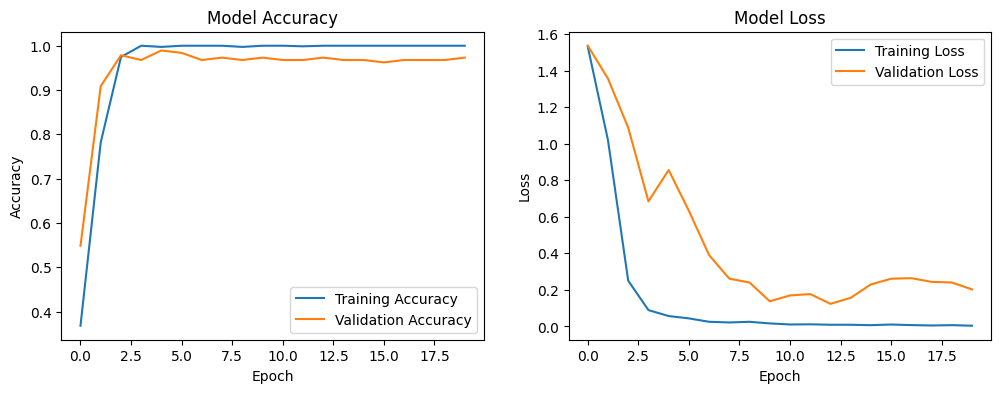

In [18]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.tight_layout()
plt.show()

### 1. LSTM Model

In [19]:
GRU_model = Sequential([
    # Embedding layer
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              input_length=max_length),
    
    # Bidirectional GRU
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.5),
    
    Bidirectional(GRU(32)),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    # Dense(128, activation='selu', kernel_initializer='lecun_normal'),
    Dropout(0.5),
    
    Dense(5, activation='softmax')
])
GRU_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
GRU_model.build(input_shape=(None, max_length))
GRU_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,509 (1.55 MB)

 Trainable params: 405,509 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [21]:
GRU_history = GRU_model.fit(
    train_padded, 
    training_label_seq,
    epochs=20,
    batch_size=32,
    validation_data=(validation_padded, validation_label_seq),
    verbose=1
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.4202 - loss: 1.5514 - val_accuracy: 0.5484 - val_loss: 1.2275
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5691 - loss: 1.0901 - val_accuracy: 0.5484 - val_loss: 0.6856
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5485 - loss: 0.7878 - val_accuracy: 0.6720 - val_loss: 0.6965
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5170 - loss: 0.7807 - val_accuracy: 0.6720 - val_loss: 0.6647
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6121 - loss: 0.7073 - val_accuracy: 0.8656 - val_loss: 0.6155
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6235 - loss: 0.6713 - val_accuracy: 0.8925 - val_loss: 0.4663
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8874 - loss: 0.3937 - val_accuracy: 0.9785 - val_loss: 0.0806
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9978 - loss: 0.0559 - val_accuracy: 0.9839 - v

### Training Performance

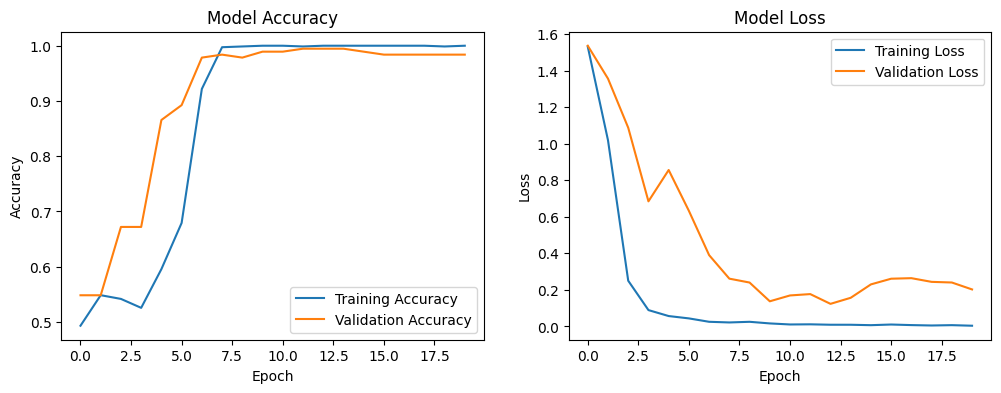

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(GRU_history.history['accuracy'], label='Training Accuracy')
plt.plot(GRU_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.tight_layout()
plt.show()

##  Results

### 1. Final Model Comparison

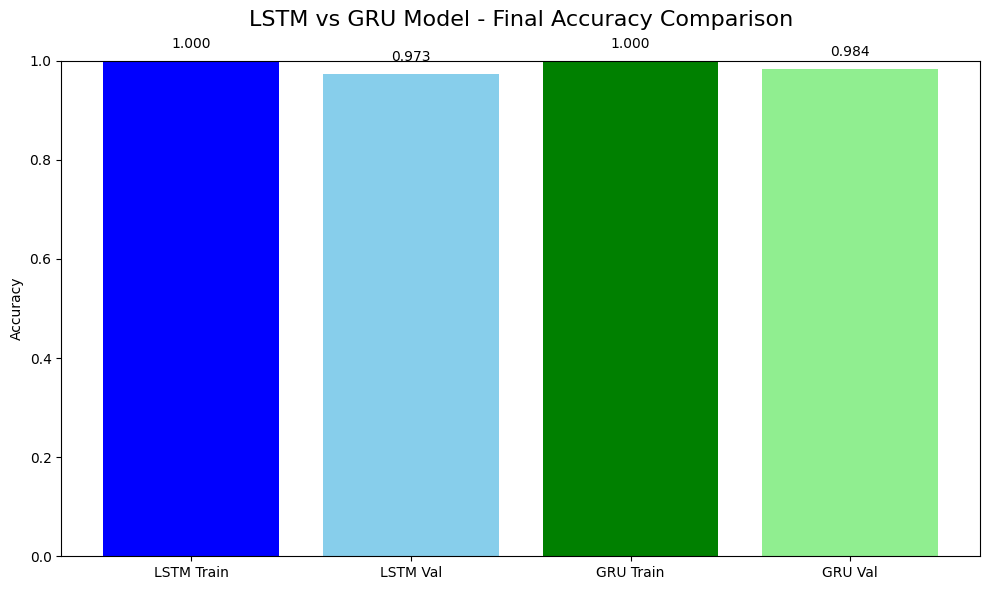

In [23]:
final_accs = {
    'LSTM Train': history.history['accuracy'][-1],
    'LSTM Val': history.history['val_accuracy'][-1],
    'GRU Train': GRU_history.history['accuracy'][-1],
    'GRU Val': GRU_history.history['val_accuracy'][-1]
}

# Plot setup
plt.figure(figsize=(10, 6))
plt.title('LSTM vs GRU Model - Final Accuracy Comparison', fontsize=16,pad=25)

# Bar chart
bars = plt.bar(final_accs.keys(), final_accs.values(), 
               color=['blue', 'skyblue', 'green', 'lightgreen'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, 
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [24]:
lstm_pred = model.predict(validation_padded)
gru_pred = GRU_model.predict(validation_padded)

lstm_pred_classes = np.argmax(lstm_pred, axis=1)
gru_pred_classes = np.argmax(gru_pred, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


### 2. confusion matrix

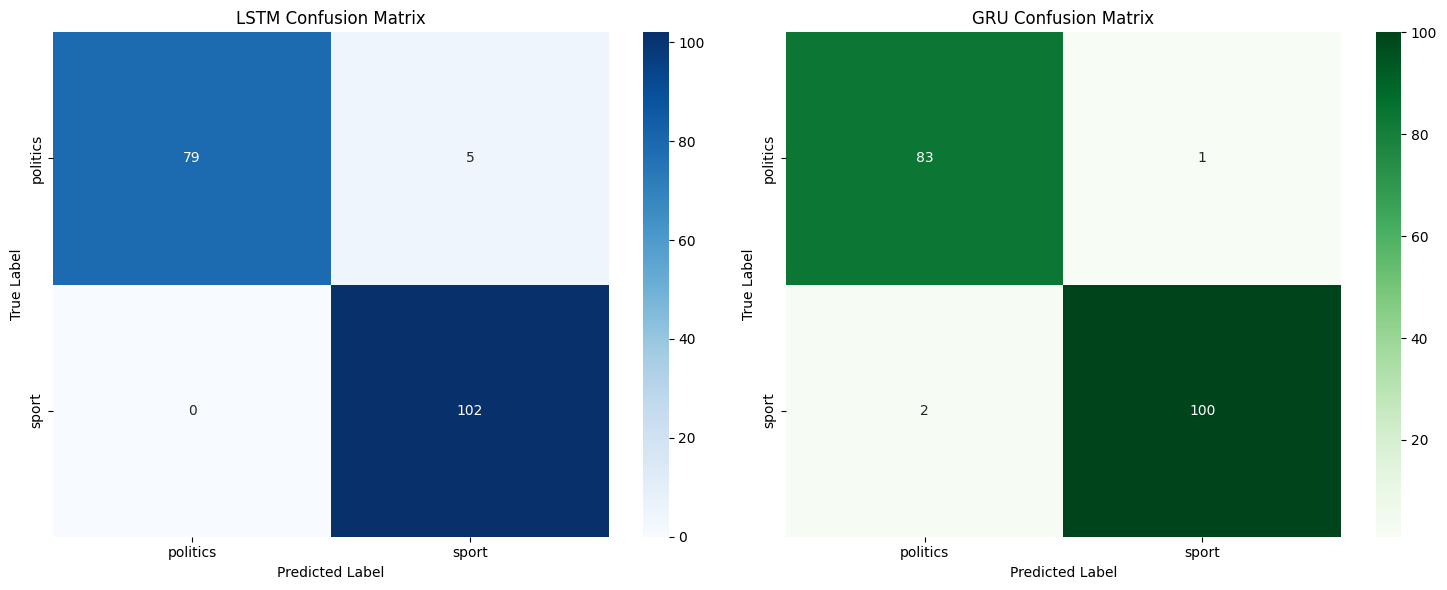

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LSTM Confusion Matrix
cm_lstm = confusion_matrix(validation_label_seq, lstm_pred_classes)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title('LSTM Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# GRU Confusion Matrix
cm_gru = confusion_matrix(validation_label_seq, gru_pred_classes)
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title('GRU Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### 3. Classification report

In [26]:
print("=" * 60)
print("LSTM CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(validation_label_seq, lstm_pred_classes, 
                          target_names=label_encoder.classes_))

print("\n" + "=" * 60)
print("GRU CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(validation_label_seq, gru_pred_classes,
                          target_names=label_encoder.classes_))

LSTM CLASSIFICATION REPORT
              precision    recall  f1-score   support

    politics       1.00      0.94      0.97        84
       sport       0.95      1.00      0.98       102

    accuracy                           0.97       186
   macro avg       0.98      0.97      0.97       186
weighted avg       0.97      0.97      0.97       186


GRU CLASSIFICATION REPORT
              precision    recall  f1-score   support

    politics       0.98      0.99      0.98        84
       sport       0.99      0.98      0.99       102

    accuracy                           0.98       186
   macro avg       0.98      0.98      0.98       186
weighted avg       0.98      0.98      0.98       186



### 4. Per-Class Performance (Best Model)

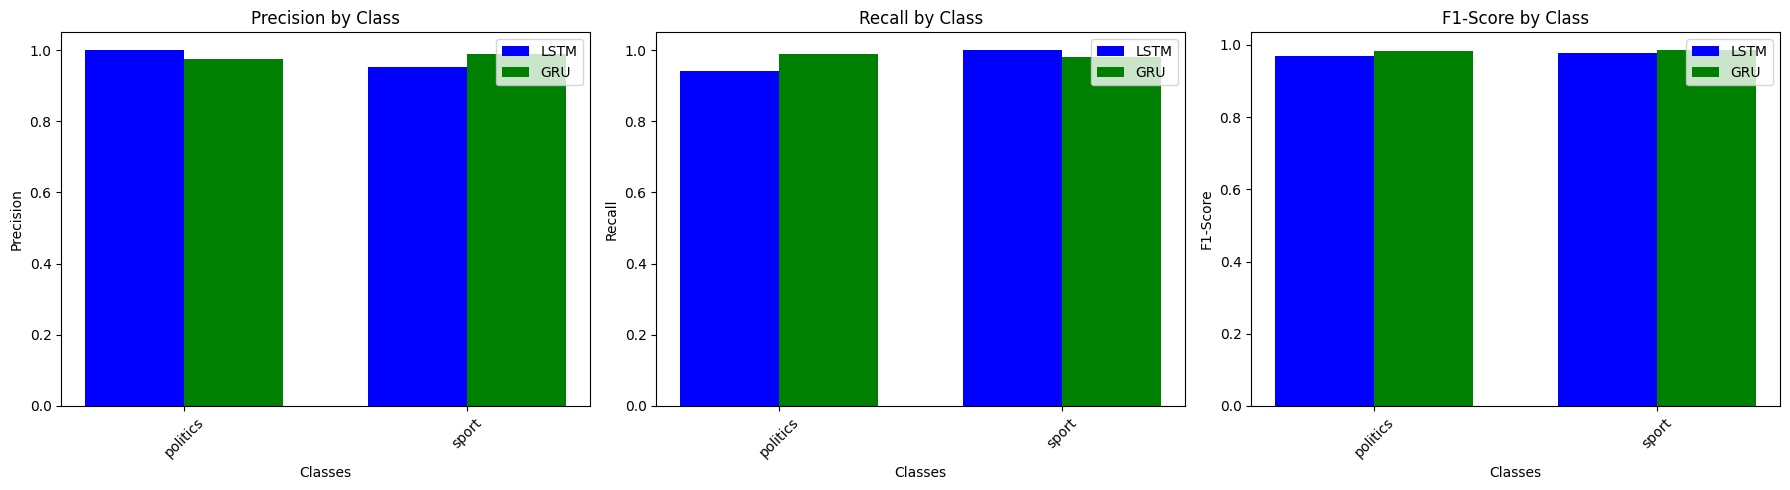


Per-Class Metrics Comparison:
      Class  LSTM_Precision  GRU_Precision  LSTM_Recall  GRU_Recall  LSTM_F1  \
0  politics           1.000          0.976         0.94       0.988    0.969   
1     sport           0.953          0.990         1.00       0.980    0.976   

   GRU_F1  
0   0.982  
1   0.985  


In [27]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics for each class
lstm_metrics = precision_recall_fscore_support(validation_label_seq, lstm_pred_classes, average=None)
gru_metrics = precision_recall_fscore_support(validation_label_seq, gru_pred_classes, average=None)

# Create comparison dataframe
metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'LSTM_Precision': lstm_metrics[0],
    'GRU_Precision': gru_metrics[0],
    'LSTM_Recall': lstm_metrics[1],
    'GRU_Recall': gru_metrics[1],
    'LSTM_F1': lstm_metrics[2],
    'GRU_F1': gru_metrics[2]
})

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision comparison
x = np.arange(len(label_encoder.classes_))
width = 0.35

axes[0].bar(x - width/2, metrics_df['LSTM_Precision'], width, label='LSTM', color='blue')
axes[0].bar(x + width/2, metrics_df['GRU_Precision'], width, label='GRU', color='green')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision by Class')
axes[0].set_xticks(x)
axes[0].set_xticklabels(label_encoder.classes_, rotation=45)
axes[0].legend()

# Recall comparison
axes[1].bar(x - width/2, metrics_df['LSTM_Recall'], width, label='LSTM', color='blue')
axes[1].bar(x + width/2, metrics_df['GRU_Recall'], width, label='GRU', color='green')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall by Class')
axes[1].set_xticks(x)
axes[1].set_xticklabels(label_encoder.classes_, rotation=45)
axes[1].legend()

# F1-score comparison
axes[2].bar(x - width/2, metrics_df['LSTM_F1'], width, label='LSTM', color='blue')
axes[2].bar(x + width/2, metrics_df['GRU_F1'], width, label='GRU', color='green')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('F1-Score by Class')
axes[2].set_xticks(x)
axes[2].set_xticklabels(label_encoder.classes_, rotation=45)
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nPer-Class Metrics Comparison:")
print(metrics_df.round(3))

### 5. Errors

In [28]:
# Find misclassified examples
lstm_errors = validation_label_seq != lstm_pred_classes
gru_errors = validation_label_seq != gru_pred_classes

# Samples where LSTM failed but GRU succeeded
lstm_fail_gru_success = lstm_errors & ~gru_errors
gru_fail_lstm_success = gru_errors & ~lstm_errors
both_fail = lstm_errors & gru_errors

print(f"LSTM errors: {np.sum(lstm_errors)} ({np.sum(lstm_errors)/len(validation_label_seq)*100:.1f}%)")
print(f"GRU errors: {np.sum(gru_errors)} ({np.sum(gru_errors)/len(validation_label_seq)*100:.1f}%)")
print(f"LSTM failed but GRU succeeded: {np.sum(lstm_fail_gru_success)}")
print(f"GRU failed but LSTM succeeded: {np.sum(gru_fail_lstm_success)}")
print(f"Both models failed: {np.sum(both_fail)}")

LSTM errors: 5 (2.7%)
GRU errors: 3 (1.6%)
LSTM failed but GRU succeeded: 4
GRU failed but LSTM succeeded: 2
Both models failed: 1
